# New Train/Val/Set

Creates new train/val/test set using the raw data

In [1]:
module("load",'cuda/11.2')
module("load","tensorflow/gpu-cuda-11.2/2.5.0")

In [2]:
import tensorflow as tf

2021-12-06 14:02:30.620686: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import utils
import scipy
import paths
import sklearn.model_selection 

In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
paths_dic = paths.get_paths()

In [6]:
df1 = pd.read_csv(paths_dic['data']+'SourceData_Figure_1.csv')
df1.loc[:,'Modified sequence'] = df1['Modified sequence'].str.replace('_','')

In [7]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(df1, df1['CCS'], random_state=3122021, stratify=df1['Charge'])

# Linear Regression

In [8]:
import regression_linear

In [9]:
lr = regression_linear.LinearRegression()
lr.fit(x_train)

In [10]:
lr.predict(df1)

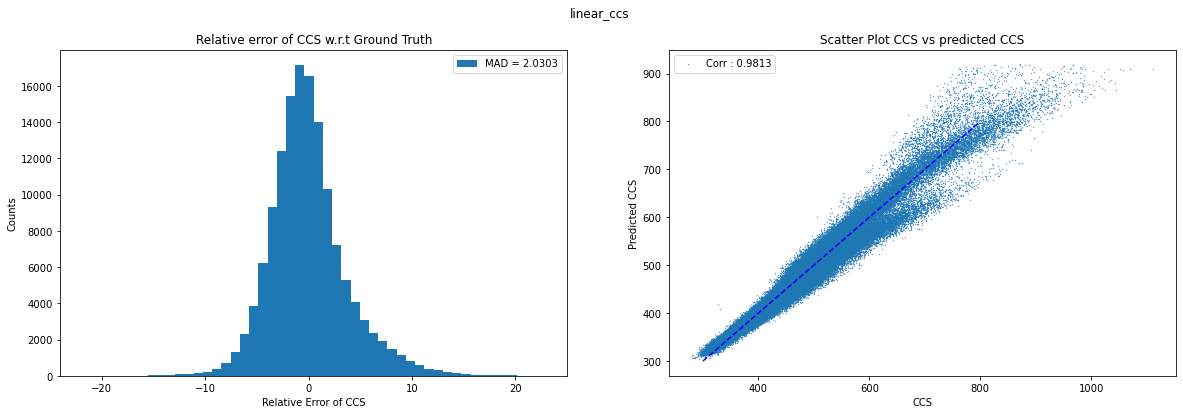

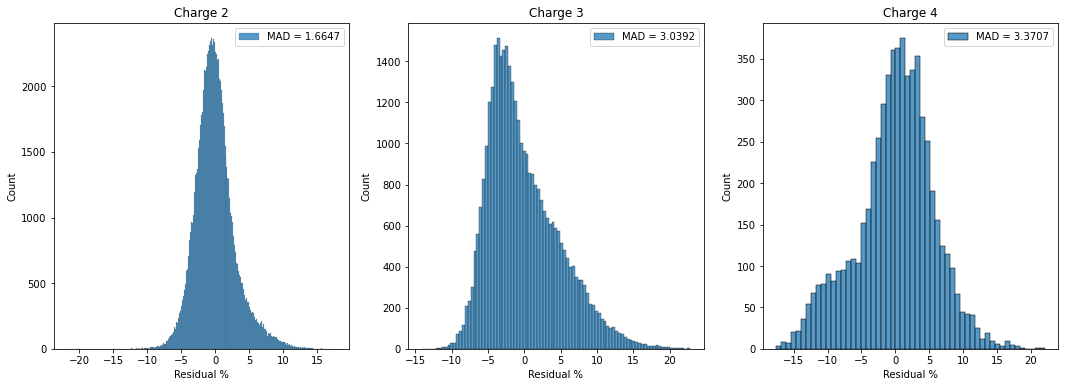

In [11]:
lr.test_set_plot(x_test)

# Power Law Regression

In [12]:
import regression_power

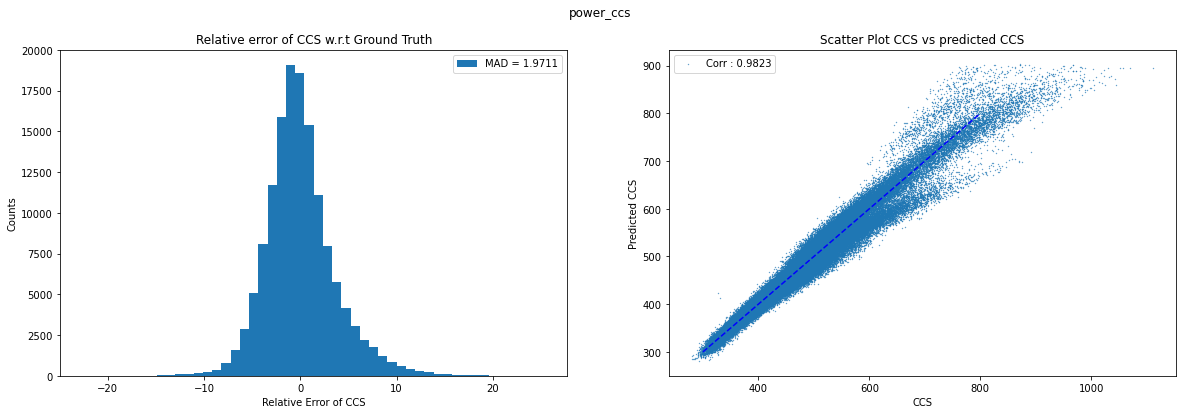

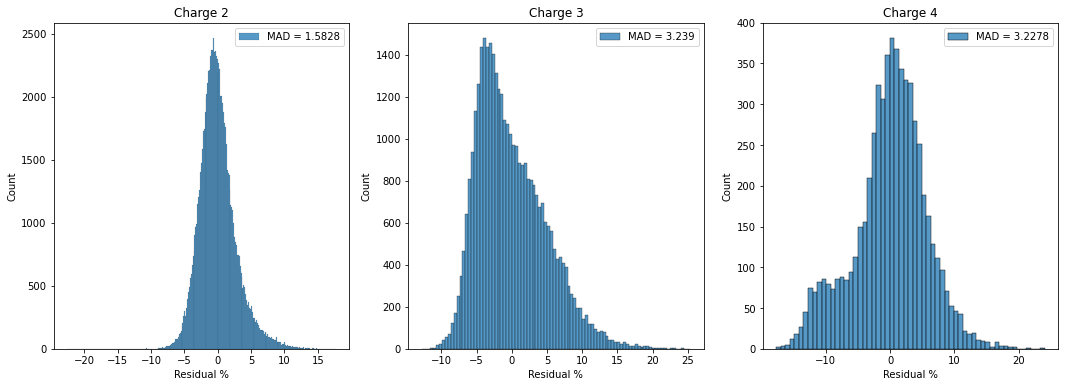

In [13]:
pl = regression_power.PowerLawRegression()
pl.fit(x_train)
pl.predict(df1)
pl.test_set_plot(x_test)

# SVR Dipeptides

In [29]:
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import BaggingRegressor
from sklearnex import patch_sklearn
import scipy

In [30]:
patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   2 out of  18 | elapsed:   11.5s remaining:  1.5min
[Parallel(n_jobs=18)]: Done  18 out of  18 | elapsed:   17.0s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   2 out of  18 | elapsed:    4.1s remaining:   32.7s
[Parallel(n_jobs=18)]: Done  18 out of  18 | elapsed:    5.8s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   2 out of  18 | elapsed:    0.6s remaining:    4.7s
[Parallel(n_jobs=18)]: Done  18 out of  18 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   2 out of  18 | elapsed:    2.8s remaining:   22.7s
[Parallel(n_jobs=18)]: Done  18 out of  18 | elapsed:    4.0s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parall

Creating histogram
Creating scatter plot


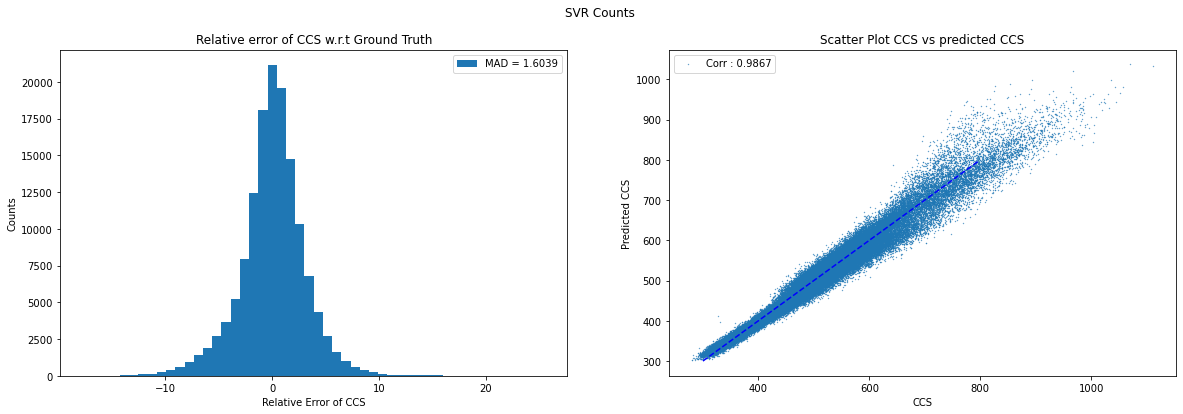

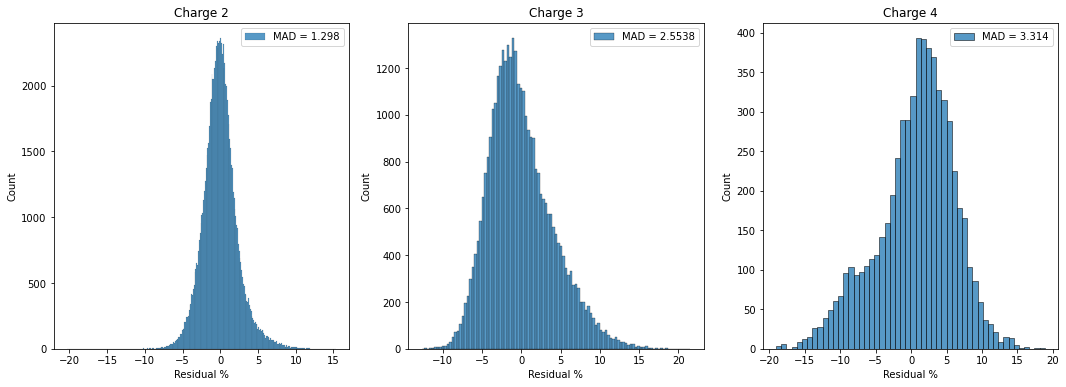

In [41]:
#Load data in

features_complete =  np.load(paths_dic['data']+'dipeptide_fig1.npy', allow_pickle=True)

#Train/Val splitv

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(features_complete, df1['CCS'], random_state=3122021, stratify=features_complete[:,-1])

#Instantiate models
n_estimators = 50
regr2 = BaggingRegressor(base_estimator=LinearSVR(dual =False, loss='squared_epsilon_insensitive'), n_estimators=n_estimators, 
random_state=0, n_jobs=-1, max_samples= 1.0/n_estimators, verbose = 1)
regr3 = BaggingRegressor(base_estimator=LinearSVR(dual =False, loss='squared_epsilon_insensitive'), n_estimators=n_estimators, 
random_state=0, n_jobs=-1, max_samples= 1.0/n_estimators, verbose = 1)
regr4 = BaggingRegressor(base_estimator=LinearSVR(dual =False, loss='squared_epsilon_insensitive'), n_estimators=n_estimators, 
random_state=0, n_jobs=-1, max_samples= 1.0/n_estimators, verbose = 1)

regr2.fit(x_train[x_train[:,-1]==2][:,:-1], y_train[x_train[:,-1]==2])
regr3.fit(x_train[x_train[:,-1]==3][:,:-1], y_train[x_train[:,-1]==3])
regr4.fit(x_train[x_train[:,-1]==4][:,:-1], y_train[x_train[:,-1]==4])

preds = pd.DataFrame(df1.loc[y_test.index][['Charge', 'CCS']], columns = ['Charge', 'CCS'])
preds['svr'] = 0

preds.loc[preds['Charge']==2, 'svr'] = regr2.predict(x_test[x_test[:,-1]==2][:,:-1]) 
preds.loc[preds['Charge']==3, 'svr'] = regr3.predict(x_test[x_test[:,-1]==3][:,:-1])
preds.loc[preds['Charge']==4, 'svr'] = regr4.predict(x_test[x_test[:,-1]==4][:,:-1])

res_rel = (preds['svr']-y_test)/y_test*100

print('Creating histogram')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
fig.suptitle('SVR Counts', fontsize = 12)
ax[0].hist(res_rel, bins = 50, label = f'MAD = {np.round(scipy.stats.median_abs_deviation(res_rel), 4)}')
ax[0].set_xlabel('Relative Error of CCS')
ax[0].set_ylabel('Counts')
ax[0].set_title('Relative error of CCS w.r.t Ground Truth')
ax[0].legend()

print('Creating scatter plot')
corr, _ = scipy.stats.pearsonr(preds['svr'],y_test)
ax[1].scatter(y_test, preds['svr'], label = f'Corr : {np.round(corr, 4)}', s = 0.1)
ax[1].set_xlabel('CCS')
ax[1].set_ylabel('Predicted CCS')
ax[1].set_title('Scatter Plot CCS vs predicted CCS')
ax[1].plot(np.arange(300,800), np.arange(300,800), 'b--')
ax[1].legend()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
i = 0
for ax, df_it in zip(ax, [preds[preds['Charge']==2], preds[preds['Charge']==3], preds[preds['Charge']==4]]):
    res_rel = (df_it['CCS']-df_it['svr'])/df_it['svr']*100
    sns.histplot(res_rel, ax = ax, label = f'MAD = {np.round(scipy.stats.median_abs_deviation(res_rel), 4)}')
    ax.set_xlabel('Residual %')
    ax.set_ylabel('Count')
    ax.set_title(f'Charge {i+2}')
    ax.legend()
    i += 1

# XGBoost - Categorical and numericall
Let's see the performance of XGBoost without any information of the sequence

In [70]:
import xgboost

In [71]:
df1_xgb = df1[['Charge', 'Mass', 'm/z', 'Experiment', 'id', 'Intensity', 'Score', 'Length', 'Retention time', 'power_ccs', 'CCS']]

In [72]:
df1_xgb['Experiment_cat'] = -1
df1_xgb.loc[df1_xgb['Experiment'].str.find('Trp') != -1,     'Experiment_cat'] = 0
df1_xgb.loc[df1_xgb['Experiment'].str.find('Tryp') != -1,     'Experiment_cat'] = 0
df1_xgb.loc[df1_xgb['Experiment'].str.find('Trypsin') != -1, 'Experiment_cat'] = 0
df1_xgb.loc[df1_xgb['Experiment'].str.find('trypsin') != -1, 'Experiment_cat'] = 0
df1_xgb.loc[df1_xgb['Experiment'].str.find('LysC') != -1,    'Experiment_cat'] = 1
df1_xgb.loc[df1_xgb['Experiment'].str.find('LysN') != -1,    'Experiment_cat'] = 2
df1_xgb['Experiment_cat'].unique()

/u/jrlopez/conda-envs/ccs/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/u/jrlopez/conda-envs/ccs/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


array([0, 2, 1])

In [73]:
df1_xgb['Experiment'].unique()

array(['HeLa_Trp_2', 'HeLa_Trypsin_1', 'HeLa_LysN', 'HeLa_LysC',
       'Drosophila_Trp', 'CElegans_Tryp', 'Drosophila_LysN',
       'Yeast_Trypsin', 'Drosophila_LysC', 'Yeast_LysC', 'Yeast_LysN',
       'Ecoli_trypsin', 'Ecoli_LysC', 'Ecoli_LysN'], dtype=object)

In [75]:
df1_xgb['Length'] = df1_xgb['Length'].astype(float)  
label = df1_xgb['CCS']
del df1_xgb['CCS'], df1_xgb['Experiment'], df1_xgb['power_ccs']

/u/jrlopez/conda-envs/ccs/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(df1_xgb, label, random_state=3122021, stratify = df1_xgb['Charge'])

In [77]:
regressor = xgboost.XGBRegressor(colsample_bytree = 1)

In [78]:
regressor.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=18, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [79]:
preds = regressor.predict(x_test)
err_rel = (y_test - preds)/preds*100

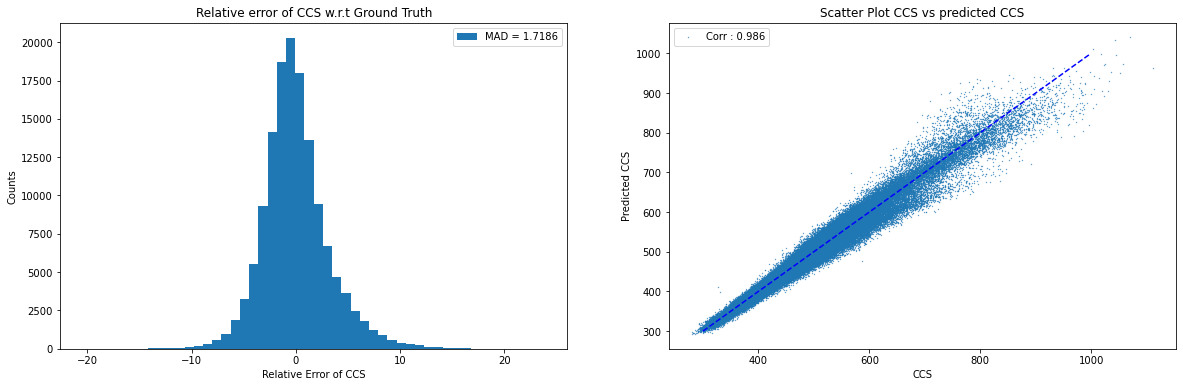

In [80]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
ax[0].hist(err_rel, bins = 50, label = f'MAD = {np.round(scipy.stats.median_abs_deviation(err_rel), 4)}')
ax[0].set_xlabel('Relative Error of CCS')
ax[0].set_ylabel('Counts')
ax[0].set_title(f'Relative error of CCS w.r.t Ground Truth')
ax[0].legend()

corr, _ = scipy.stats.pearsonr(y_test.values, preds.flatten())
ax[1].scatter(y_test.values,preds, label = f'Corr : {np.round(corr, 3)}', s = 0.1)
ax[1].set_xlabel('CCS')
ax[1].set_ylabel('Predicted CCS')
ax[1].set_title(f'Scatter Plot CCS vs predicted CCS')
ax[1].plot(np.arange(300,1000), np.arange(300,1000), 'b--')
ax[1].legend()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

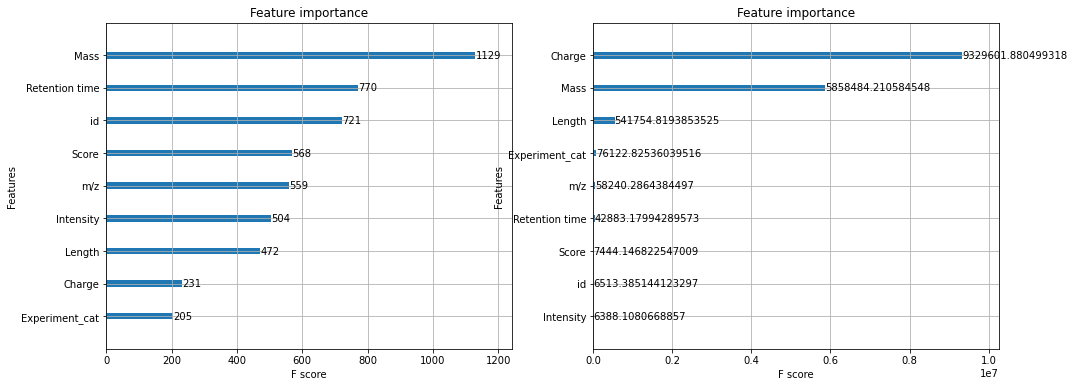

In [81]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
xgboost.plot_importance(regressor, importance_type="weight", ax = ax[0])
xgboost.plot_importance(regressor, importance_type="gain", ax = ax[1])

# Transformer

## Charge 2 and LysN

Only datapoints with charge = 2 and diggested with LysN 

In [100]:
import regression_transformers

In [85]:
#Everything for charge 2
charge = 2
df1_ch2 = df1[df1['Charge']==charge]
df1_ch2_enz = df1_ch2[df1_ch2['Experiment'].str.find('LysN') != -1]
df1_ch2_enz

encoded =  np.load(paths_dic['data']+'encoded_fig1.npy', allow_pickle=True)
encoded_df = pd.DataFrame(encoded, index = df1.index)
encoded_ch2 = encoded_df[encoded_df.iloc[:,-1]==charge].iloc[:,:-1]
encoded_ch2_enz = encoded_ch2.loc[df1_ch2_enz.index]

In [86]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(encoded_ch2_enz, df1_ch2_enz['CCS'] - df1_ch2_enz['power_ccs'], 
                                                                            random_state=3122021)

In [87]:
model, optimizer = regression_transformers.architecutre(x_train)
model.compile(loss='mean_squared_error', optimizer=optimizer)

Starts calling architecture routines


2021-12-06 14:59:01.262304: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-06 14:59:01.344116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:31:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.305GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-12-06 14:59:01.344166: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-06 14:59:01.352698: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-06 14:59:01.352788: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-12-06 14:59:01.400916: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft

Calss keras.Model
optimizer
Summary
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 66)]         0                                            
__________________________________________________________________________________________________
tf.math.equal (TFOpLambda)      (None, 66)           0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 66)           0           tf.math.equal[0][0]              
__________________________________________________________________________________________________
token_and_position_embedding (T (None, 66, 256)      23808       input_1[0][0]                    
__________________________________________________________

In [88]:
history = model.fit(
    x_train, y_train, batch_size=64, epochs=35, validation_data=(x_test, y_test),
)

2021-12-06 15:02:08.172832: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-06 15:02:08.204398: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz


Epoch 1/35


2021-12-06 15:02:09.883383: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 13/824 [..............................] - ETA: 10s - loss: 103.1296

2021-12-06 15:02:10.746081: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-12-06 15:02:10.746175: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


824/824 [==============================] - 16s 16ms/step - loss: 58.9795 - val_loss: 39.7427
Epoch 2/35
824/824 [==============================] - 13s 15ms/step - loss: 42.7735 - val_loss: 39.2356
Epoch 3/35
824/824 [==============================] - 12s 15ms/step - loss: 42.6091 - val_loss: 46.6838
Epoch 4/35
824/824 [==============================] - 13s 15ms/step - loss: 42.0665 - val_loss: 42.3140
Epoch 5/35
824/824 [==============================] - 13s 15ms/step - loss: 41.6363 - val_loss: 37.4703
Epoch 6/35
824/824 [==============================] - 13s 15ms/step - loss: 40.7029 - val_loss: 39.1965
Epoch 7/35
824/824 [==============================] - 13s 15ms/step - loss: 40.2127 - val_loss: 38.5016
Epoch 8/35
824/824 [==============================] - 13s 16ms/step - loss: 39.2836 - val_loss: 37.5813
Epoch 9/35
824/824 [==============================] - 14s 16ms/step - loss: 39.1110 - val_loss: 37.1335
Epoch 10/35
824/824 [==============================] - 13s 15ms/step - loss

In [89]:
pred_ccs = model.predict(x_test).flatten() + df1_ch2_enz.loc[y_test.index, 'power_ccs'].values
err_rel = (df1_ch2_enz.loc[y_test.index, 'CCS'].values - pred_ccs)/pred_ccs*100

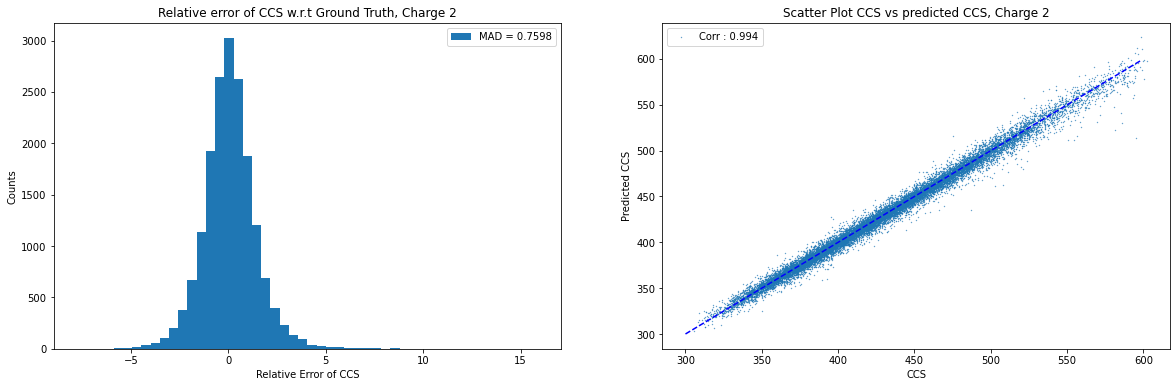

In [90]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
ax[0].hist(err_rel, bins = 50, label = f'MAD = {np.round(scipy.stats.median_abs_deviation(err_rel), 4)}')
ax[0].set_xlabel('Relative Error of CCS')
ax[0].set_ylabel('Counts')
ax[0].set_title(f'Relative error of CCS w.r.t Ground Truth, Charge {charge}')
ax[0].legend()

corr, _ = scipy.stats.pearsonr(df1_ch2_enz.loc[y_test.index, 'CCS'].values, pred_ccs.flatten())
ax[1].scatter(df1_ch2_enz.loc[y_test.index, 'CCS'],pred_ccs, label = f'Corr : {np.round(corr, 3)}', s = 0.1)
ax[1].set_xlabel('CCS')
ax[1].set_ylabel('Predicted CCS')
ax[1].set_title(f'Scatter Plot CCS vs predicted CCS, Charge {charge}')
ax[1].plot(np.arange(300,600), np.arange(300,600), 'b--')
ax[1].legend()

## Concatenated

In [122]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(encoded_df.iloc[:,:-1], label, random_state=3122021, 
                                                                            stratify = encoded_df.iloc[:,-1])

In [123]:
extra_features_train = df1_xgb.loc[x_train.index, ['Charge', 'Mass', 'Experiment_cat', 'Length']]
extra_features_test = df1_xgb.loc[x_test.index, ['Charge', 'Mass', 'Experiment_cat', 'Length']]

In [124]:
model_sv, optimizer = regression_transformers.architecture_seq_vec(x_train)
model_sv.compile(loss='mean_squared_error', optimizer=optimizer)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 66)]         0                                            
__________________________________________________________________________________________________
tf.math.equal_4 (TFOpLambda)    (None, 66)           0           input_8[0][0]                    
__________________________________________________________________________________________________
tf.cast_4 (TFOpLambda)          (None, 66)           0           tf.math.equal_4[0][0]            
__________________________________________________________________________________________________
token_and_position_embedding_4  (None, 66, 256)      23808       input_8[0][0]                    
____________________________________________________________________________________________

In [131]:
model_sv.fit(x=[x_train, extra_features_train], y=y_train, batch_size=64, epochs=30, 
             validation_data=([x_test, extra_features_test], y_test),)

Epoch 1/30
6563/6563 [==============================] - 64s 10ms/step - loss: 5591.0581 - val_loss: 570.5664
Epoch 2/30
6563/6563 [==============================] - 64s 10ms/step - loss: 5609.2949 - val_loss: 424.1723
Epoch 3/30
6563/6563 [==============================] - 64s 10ms/step - loss: 5603.7256 - val_loss: 467.0180
Epoch 4/30
6563/6563 [==============================] - 64s 10ms/step - loss: 5584.8286 - val_loss: 477.0326
Epoch 5/30
6563/6563 [==============================] - 70s 11ms/step - loss: 5590.6587 - val_loss: 420.0696
Epoch 6/30
6563/6563 [==============================] - 112s 17ms/step - loss: 5560.7798 - val_loss: 597.2817
Epoch 7/30
6563/6563 [==============================] - 113s 17ms/step - loss: 5532.1885 - val_loss: 426.5630
Epoch 8/30
6563/6563 [==============================] - 85s 13ms/step - loss: 5489.3496 - val_loss: 599.6793
Epoch 9/30
6563/6563 [==============================] - 64s 10ms/step - loss: 5546.0547 - val_loss: 572.9965
Epoch 10/30
6563/

In [127]:
pred_ccs = model_sv.predict([x_test, extra_features_test]).flatten()
err_rel = (y_test - pred_ccs)/pred_ccs*100

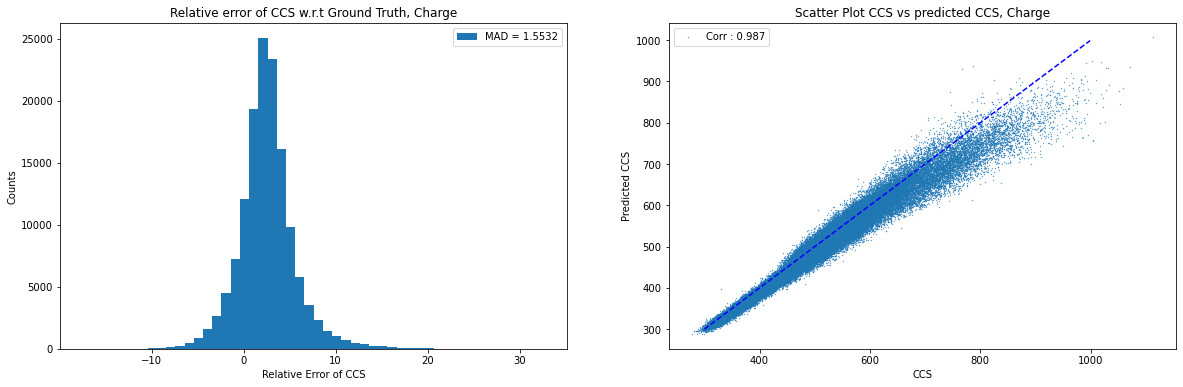

In [130]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
ax[0].hist(err_rel, bins = 50, label = f'MAD = {np.round(scipy.stats.median_abs_deviation(err_rel), 4)}')
ax[0].set_xlabel('Relative Error of CCS')
ax[0].set_ylabel('Counts')
ax[0].set_title(f'Relative error of CCS w.r.t Ground Truth, Charge')
ax[0].legend()

corr, _ = scipy.stats.pearsonr(y_test, pred_ccs.flatten())
ax[1].scatter(y_test,pred_ccs, label = f'Corr : {np.round(corr, 3)}', s = 0.1)
ax[1].set_xlabel('CCS')
ax[1].set_ylabel('Predicted CCS')
ax[1].set_title(f'Scatter Plot CCS vs predicted CCS, Charge')
ax[1].plot(np.arange(300,1000), np.arange(300,1000), 'b--')
ax[1].legend()